In [1]:
dataset_url = "https://www.kaggle.com/api/v1/datasets/download/rm1000/lung-cancer-histopathological-images"
from google.colab import drive
import os

# mount drive
drive.mount('/content/drive', force_remount=True)

basedir = "/content/drive/MyDrive/Colab Notebooks/visualintelligence/CNN/"
#basedir = "" # for local execution
datasetdir = "/content/drive/MyDrive/Colab Notebooks/visualintelligence/"

# install requirements in the parent folder
requirements_path = "'/content/drive/MyDrive/Colab Notebooks/visualintelligence/requirements.txt'"
!pip install -r {requirements_path}

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torchvision.io.image import decode_jpeg, read_file
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil
from sklearn.model_selection import StratifiedKFold
import random
from PIL import Image
import torch.multiprocessing as mp
from functools import lru_cache
from torchvision.io import read_image, ImageReadMode
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode
from collections import OrderedDict
from functools import lru_cache
from tqdm.auto import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from zipfile import ZipFile
from functools import lru_cache
import json
import torch
from torch.cuda.amp import autocast, GradScaler

In [3]:
# setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

import multiprocessing

num_cores = min(multiprocessing.cpu_count(), 4)
print(f"Number of cores: {num_cores}")

Using cuda
Number of cores: 2


In [4]:
ADENOCARCINOMA = "adenocarcinoma"
SQUAMOUS_CELL_CARCINOMA = "squamous_cell_carcinoma"
BENIGN = "benign"

class_0 = BENIGN
class_1 = ADENOCARCINOMA

In [5]:
import glob
def dataset_exists(path = "/content/dataset", no_files = 10000):
  # check if dir exists and contains at least no_files files
  if not os.path.exists(path):
    print(f"Folder not found in {path}")
    return False
  if len(list(glob.iglob(path + "/**", recursive=True))) < no_files:
    print(f"Not enough files in {path}")
    return False
  print(f"Dataset found in {path}")
  return True

if not dataset_exists():
  pass
  with ZipFile(datasetdir + "dataset.zip", "r") as zip_ref:
      zip_ref.extractall()
  # move folders to the right place
  os.makedirs("dataset", exist_ok=True)
  shutil.move(ADENOCARCINOMA, "dataset")
  shutil.move(SQUAMOUS_CELL_CARCINOMA, "dataset")
  shutil.move(BENIGN, "dataset")

Dataset found in /content/dataset


Number of files in benign folder: 5000
Number of files in adenocarcinoma folder: 5000
   filename   class
0  4804.jpg  benign
1  0180.jpg  benign
2  3694.jpg  benign
3  3915.jpg  benign
4  3767.jpg  benign


Text(0.5, 1.0, 'Class distribution')

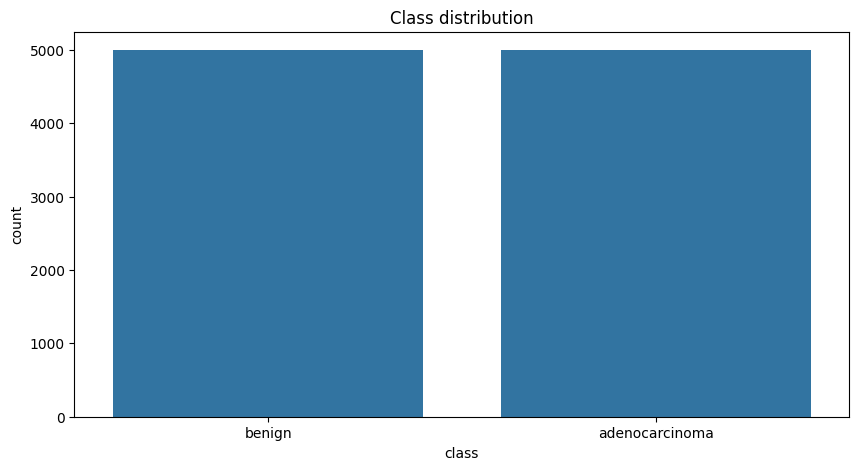

In [6]:
# Creating lists for dataframe construction
allFilesClass0 = os.listdir(f"dataset/{class_0}")
allFilesClass1 = os.listdir(f"dataset/{class_1}")

print(f"Number of files in {class_0} folder: {len(allFilesClass0)}")
print(f"Number of files in {class_1} folder: {len(allFilesClass1)}")

df = pd.DataFrame(columns=["filename", "class"])
df["filename"] = allFilesClass0 + allFilesClass1
df["class"] = [class_0] * len(allFilesClass0) + [class_1] * len(allFilesClass1)

# Displaying the dataframe
print(df.head())

# Displaying the class distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="class")
plt.title("Class distribution")

In [7]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

def compute_class_color(class_path):
    """
    Calcola il colore medio per una classe di immagini
    """
    rgb_means = []
    files = os.listdir(class_path)

    for file in tqdm(files, desc=f"Processing {os.path.basename(class_path)}"):
        img_path = os.path.join(class_path, file)
        img = np.array(Image.open(img_path))
        rgb_mean = np.mean(img, axis=(0,1))
        rgb_means.append(rgb_mean)

    class_mean = np.mean(rgb_means, axis=0)
    class_std = np.std(rgb_means, axis=0)
    return class_mean, class_std

def visualize_class_colors(benign_color, cancer_color):
    """
    Visualizza i colori medi delle classi
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

    ax1.imshow([[benign_color/255]])
    ax1.set_title('Benign Average Color')
    ax1.axis('off')

    ax2.imshow([[cancer_color/255]])
    ax2.set_title('Cancer Average Color')
    ax2.axis('off')

    plt.show()

# Calcolo colori medi
#benign_path = "dataset/benign"
#cancer_path = f"dataset/{ADENOCARCINOMA}"
#
#benign_color, benign_std = compute_class_color(benign_path)
#cancer_color, cancer_std = compute_class_color(cancer_path)
#
#print(f"Benign average RGB: {benign_color}, std: {benign_std}")
#print(f"Cancer average RGB: {cancer_color}, std: {cancer_std}")
#
## Visualizza risultati
#visualize_class_colors(benign_color, cancer_color)

In [8]:
# Performing a stratified k-folds subdivision
KFOLDS = 10
skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=42)
skf.get_n_splits(df["filename"], df["class"])

# Storing indexes to reuse them later
train_indexes = []
val_indexes = []
for train_index, val_index in skf.split(df["filename"], df["class"]):
    train_indexes.append(train_index)
    val_indexes.append(val_index)

train_splits = pd.DataFrame(columns=[f"train_{i}" for i in range(KFOLDS)])
val_splits = pd.DataFrame(columns=[f"val_{i}" for i in range(KFOLDS)])

for i in range(KFOLDS):
    train_splits[f"train_{i}"] = train_indexes[i]
    val_splits[f"val_{i}"] = val_indexes[i]

# Saving the splits
train_splits.to_csv(basedir + "train_splits.csv", index=False)
val_splits.to_csv(basedir + "val_splits.csv", index=False)

In [9]:
# recover the splits
train_splits = pd.read_csv(basedir + "train_splits.csv")
val_splits = pd.read_csv(basedir + "val_splits.csv")

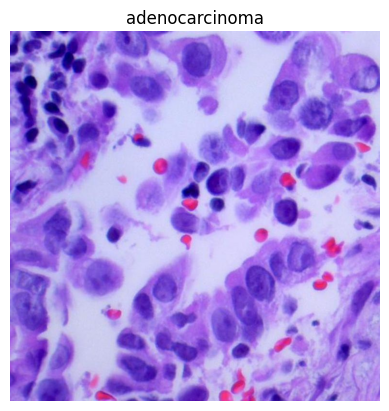

Image size: (768, 768)
Image mode: RGB


In [10]:
# image inspection
def inspect_image_randomly(df, dataset_path = "dataset"):
    idx = random.choice(range(len(df)))
    image = Image.open(f"{dataset_path}/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}")
    plt.imshow(image)
    plt.title(df.iloc[idx]["class"])
    plt.axis("off")
    plt.show()
    # print metadata
    print(f"Image size: {image.size}")
    print(f"Image mode: {image.mode}")

inspect_image_randomly(df)


In [11]:
# Finding all the unique shapes of the images inside the dataset
#shapes = []
#for idx in tqdm(range(len(df))):
#    image = Image.open(f"dataset/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}")
#    shapes.append(image.size)
#
#shapes = np.array(shapes)
#unique_shapes = np.unique(shapes, axis=0)
#print(f"Unique shapes: {unique_shapes}") # 768x768

In [12]:
TARGET_IMAGE_SIZE = 768

In [13]:
import cv2

def resize_dataset(df, size):
    new_folder = "dataset_resized"
    os.makedirs(new_folder, exist_ok=True)
    for idx in tqdm(range(len(df))):
        # Read image with OpenCV
        img_path = f"dataset/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}"
        image = cv2.imread(img_path)

        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Resize
        result = cv2.resize(gray, size)

        # Save
        dest_path = f"{new_folder}/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}"
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        cv2.imwrite(dest_path, result)

if not dataset_exists("dataset_resized"):
  resize_dataset(df, (TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE))

Dataset found in dataset_resized


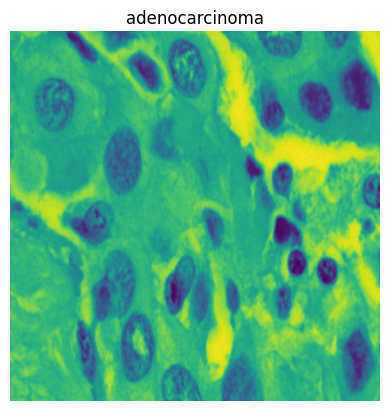

Image size: (768, 768)
Image mode: L


In [14]:

inspect_image_randomly(df, "dataset_resized")

In [15]:
# Calcolo colori medi
#benign_path = "dataset_resized/benign"
#cancer_path = f"dataset_resized/{ADENOCARCINOMA}"
#
#benign_color, benign_std = compute_class_color(benign_path)
#cancer_color, cancer_std = compute_class_color(cancer_path)
#
#print(f"Benign average RGB: {benign_color}, std: {benign_std}")
#print(f"Cancer average RGB: {cancer_color}, std: {cancer_std}")
#
## Visualizza risultati
#visualize_class_colors(benign_color, cancer_color)

In [16]:
class LungCancerDataset(Dataset):
    def __init__(self, df, folder_path, transform=None, cache_size=100):
        self.df = df
        self.folder_path = folder_path
        self.transform = transform
        self.cache_size = cache_size
        self.cache = {}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if idx in self.cache:
            image, label = self.cache[idx]
        else:
            img_name = self.df.iloc[idx]["filename"]
            img_class = self.df.iloc[idx]["class"]
            img_path = os.path.join(self.folder_path, img_class, img_name)

            # Load and cache image
            # image = Image.open(img_path).convert("RGB")
            # image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1) / 255
            data = read_file(img_path)
            # decode rgb
            #image = decode_jpeg(data, device=device).half() / 255
            # decode grayscale
            image = decode_jpeg(data, device=device, mode=ImageReadMode.GRAY) / 255

            label = 1 if img_class == class_1 else 0
            label = torch.tensor(label, dtype=torch.long)

            # Add to cache
            if len(self.cache) < self.cache_size:
                self.cache[idx] = (image, label)

        if self.transform:
            image = self.transform(image)

        return image, label

In [17]:
def calculate_fold_stats(df, train_idx, image_size=TARGET_IMAGE_SIZE, is_gray = True):
    """Calculate mean and std for a specific fold"""

    # Create dataset for train fold
    train_df = df.iloc[train_idx]
    train_dataset = LungCancerDataset(train_df, "dataset_resized")

    # Calculate mean and std
    channels = 1 if is_gray else 3
    channels_sum = torch.zeros(channels, device=device)
    channels_squared_sum = torch.zeros(channels, device=device)
    num_batches = 0

    for data, _ in tqdm(
        DataLoader(
            train_dataset,
            batch_size=32, # with 128 does not work
        ),
        desc="Calculating dataset statistics",
    ):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [18]:
def create_dataloaders(
    df, train_idx, val_idx, mean, std, batch_size=32, image_size=TARGET_IMAGE_SIZE
):
    """Create normalized dataloaders for a specific fold"""

    # Define transforms
    train_transform = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomResizedCrop(768, scale=(0.8, 1.0)),
            transforms.RandomGrayscale(p=0.1),
            transforms.Normalize(mean=mean, std=std),
        ]
    )

    val_transform = transforms.Compose(
        [
            transforms.Normalize(mean=mean, std=std),
        ]
    )

    # Create datasets
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_dataset = LungCancerDataset(train_df, "dataset_resized", transform=train_transform)
    val_dataset = LungCancerDataset(val_df, "dataset_resized", transform=val_transform)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

In [19]:
# Computing stats
#fold_stats = {}
#for fold in range(KFOLDS):
#    print(f"Processing fold {fold}")
#    train_idx = train_splits[f"train_{fold}"].values
#    val_idx = val_splits[f"val_{fold}"].values
#
#    # Calculate statistics for this fold
#    mean, std = calculate_fold_stats(df, train_idx)
#    fold_stats[fold] = {"mean": mean, "std": std}
#
#    # Create dataloaders with fold-specific normalization
#    train_loader, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)
#
#    # Print fold statistics
#    print(f"Mean: {mean}")
#    print(f"Std: {std}\n")
#
## Save fold statistics
#print("Stats: ", fold_stats)
#print("Saving fold statistics...")
## delete old file
#with open(basedir +"fold_stats.json", "w") as f:
#    json.dump(
#        {
#            k: {"mean": v["mean"].tolist(), "std": v["std"].tolist()}
#            for k, v in fold_stats.items()
#        },
#        f,
#    )

In [20]:
# load fold statistics
with open(basedir + "fold_stats.json", "r") as f:
    fold_stats = json.load(f)
print(fold_stats)

{'0': {'mean': [0.6420673131942749], 'std': [0.17046400904655457]}, '1': {'mean': [0.6424828767776489], 'std': [0.17028209567070007]}, '2': {'mean': [0.6420707702636719], 'std': [0.17056773602962494]}, '3': {'mean': [0.6423841714859009], 'std': [0.17052213847637177]}, '4': {'mean': [0.642162561416626], 'std': [0.1705571711063385]}, '5': {'mean': [0.642122745513916], 'std': [0.17047101259231567]}, '6': {'mean': [0.6421867609024048], 'std': [0.17043305933475494]}, '7': {'mean': [0.6420846581459045], 'std': [0.17053069174289703]}, '8': {'mean': [0.6423062682151794], 'std': [0.1704246699810028]}, '9': {'mean': [0.642024040222168], 'std': [0.17045168578624725]}}


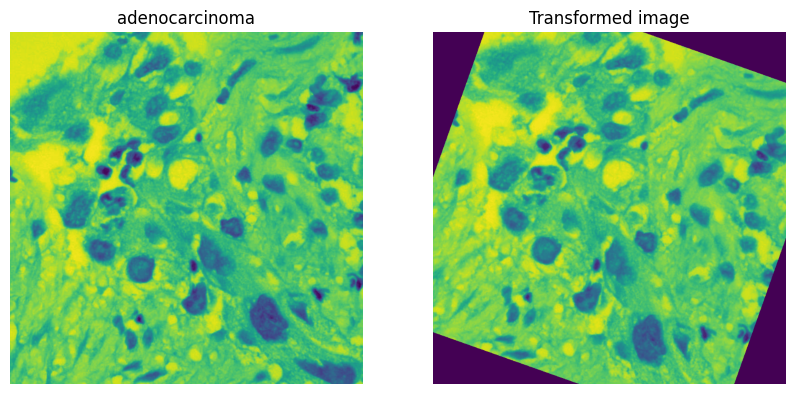

In [21]:
# Display a random image from the dataset
idx = random.choice(range(len(df)))
# read as gray scale
image = Image.open(f"dataset_resized/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title(df.iloc[idx]["class"])
ax[0].axis("off")

# Display the image after applying the transforms
transform = transforms.Compose(
    [
        # also add brightness change
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(mean=fold_stats["0"]["mean"], std=fold_stats["0"]["std"]),
    ]
)

transformed_image = transform(image)
transformed_image = transformed_image.permute(1, 2, 0)

ax[1].imshow(transformed_image)
ax[1].set_title("Transformed image")
ax[1].axis("off")
plt.show()

In [22]:
# take the data from the first fold
train_idx = train_splits["train_0"].values
val_idx = val_splits["val_0"].values
mean = fold_stats["0"]["mean"]
std = fold_stats["0"]["std"]

# Create dataloaders with fold-specific normalization
train_loader, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)

# check len of train and val loaders
print(f"Train loader length: {len(train_loader)}")
print(f"Val loader length: {len(val_loader)}")

Train loader length: 282
Val loader length: 32


In [23]:
# benchmark the dataloaders
#def benchmark_dataloader(loader, num_epochs=1):
#    for epoch in range(num_epochs):
#        for i, (data, target) in enumerate(tqdm(loader, desc=f"Epoch {epoch}")):
#            pass
#
#
#benchmark_dataloader(train_loader, num_epochs=1)
#benchmark_dataloader(val_loader, num_epochs=1)

In [24]:
# show the content of the first batch
#for i_batch, (images, labels) in enumerate(train_loader):
#    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
#    for i, ax in enumerate(axes.flatten()):
#        img = images[i].permute(1, 2, 0).to("cpu").float()
#        ax.imshow(img)
#        ax.set_title(f"Label: {labels[i].item()}")
#        ax.axis("off")
#        ax.set_title("Adenocarcinoma" if labels[i] == 1 else "Benign")
#    plt.tight_layout()
#    plt.show()
#    break

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.dropout = nn.Dropout2d(0.1)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.dropout(out)
        out = self.relu(out)
        return out

class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 5, stride=2, padding=2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        # Reduce network depth and width
        self.layer1 = ResidualBlock(8, 16)
        self.layer2 = ResidualBlock(16, 32, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(32, num_classes)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu', a=0.1)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 0.5)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Instantiate model
model = ResNetClassifier()
model = model.to(device)


In [26]:
# getting a single image from the batch
images, labels = next(iter(train_loader))
print(f"Labels : {labels}")

print(f"Images shape: {images.shape}")
image = images[0].unsqueeze(0).to(device)
label = labels[0].unsqueeze(0).to(device)

# Forward pass
model.eval()
with torch.inference_mode():
    output = model(image.float())
    print(output)

# check the model summary
print(
    summary(
        model, input_size=(1, 1, TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE), device=device
    )
)

Labels : tensor([1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 0])
Images shape: torch.Size([32, 1, 768, 768])
tensor([[-0.1185, -0.0763]], device='cuda:0')
Layer (type:depth-idx)                   Output Shape              Param #
ResNetClassifier                         [1, 2]                    --
├─Sequential: 1-1                        [1, 8, 192, 192]          --
│    └─Conv2d: 2-1                       [1, 8, 384, 384]          208
│    └─BatchNorm2d: 2-2                  [1, 8, 384, 384]          16
│    └─ReLU: 2-3                         [1, 8, 384, 384]          --
│    └─MaxPool2d: 2-4                    [1, 8, 192, 192]          --
├─ResidualBlock: 1-2                     [1, 16, 192, 192]         --
│    └─Conv2d: 2-5                       [1, 16, 192, 192]         1,168
│    └─BatchNorm2d: 2-6                  [1, 16, 192, 192]         32
│    └─ReLU: 2-7                         [1, 16, 192, 192]         --
│    └─Co

In [27]:
#from torch.profiler import profile, record_function, ProfilerActivity
#
#with profile(
#    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
#    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
#    on_trace_ready=torch.profiler.tensorboard_trace_handler("profile"),
#) as prof:
#    for images, labels in train_loader:
#        images, labels = images.to(device), labels.to(device)
#        output = model(images.float())
#        loss = F.cross_entropy(output, labels)
#        loss.backward()
#        prof.step()
#        if prof.step_num == 40:
#            break
#
#print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))
#print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
#print("Profiling finished.")

In [28]:
# Defining the operations to do in a training step
import torch.nn.utils as nn_utils

def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    epoch: int,
):

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through DataLoader batches
    for _, (img, label) in enumerate(dataloader):
        # Warmup
        warmup_percent = min(epoch / 3, 1.0)
        current_lr = 5e-4 * warmup_percent
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
        # Send data to target device
        X = img.to(device)
        y = label.to(device)
        y_pred = model(X)
        # Calculate loss
        loss = loss_fn(y_pred, y)
        # Accumulate loss
        train_loss += loss.item()
        # Optimizer zero grad
        optimizer.zero_grad()
        # Loss backward
        loss.backward()
        nn_utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Optimize step with scaler
        optimizer.step()
        # Calculate and accumulate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics for average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [29]:
def val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
):
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for _, (img, label) in enumerate(dataloader):
            X = img.to(device)
            y = label.to(device)

            val_pred_logits = model(X)
            loss = loss_fn(val_pred_logits, y)

            val_loss += loss.item()
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += (val_pred_labels == y).sum().item() / len(val_pred_labels)

    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [30]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 50,
    split: int = 0,
    patience: int = 5,
    min_delta: float = 0.001,
):
    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Initialize early stopping variables
    best_val_loss = float("inf")
    epochs_without_improvement = 0

    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=5, T_mult=1, eta_min=1e-6
    )
    # Initialize tracking for best model
    best_val = 0

    # Training loop
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            epoch=epoch,
        )

        val_loss, val_acc = val_step(
            model=model, dataloader=val_dataloader, loss_fn=loss_fn
        )

        # Update learning rate based on validation loss
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Save best model
        if val_acc > best_val:
            best_val = val_acc
            checkpoint = {
                "model": ResNetClassifier(),
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            checkpoint_name = basedir + "checkpoint_" + str(split) + ".pth"
            torch.save(checkpoint, checkpoint_name)

        # Print training progress
        tqdm.write(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # Store results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

    return results

In [31]:
## These lines take a lot of time; you will load the trained model in the following

# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set hyperparameters
NUM_EPOCHS = 50
PATIENCE = 10
MIN_DELTA = 0.001

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# model = model.to(device)

# Train model with early stopping and LR scheduling
model_results = train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    split=0,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  2%|▏         | 1/50 [01:17<1:03:02, 77.19s/it]

Epoch: 1 | train_loss: 0.6975 | train_acc: 0.4895 | val_loss: 0.6976 | val_acc: 0.4414


  4%|▍         | 2/50 [02:27<58:21, 72.95s/it]  

Epoch: 2 | train_loss: 0.5658 | train_acc: 0.7347 | val_loss: 0.5119 | val_acc: 0.8252


  6%|▌         | 3/50 [03:36<55:43, 71.14s/it]

Epoch: 3 | train_loss: 0.4778 | train_acc: 0.8132 | val_loss: 0.6166 | val_acc: 0.5166


  8%|▊         | 4/50 [04:46<54:24, 70.97s/it]

Epoch: 4 | train_loss: 0.4266 | train_acc: 0.8278 | val_loss: 0.3072 | val_acc: 0.9072


 10%|█         | 5/50 [05:55<52:37, 70.17s/it]

Epoch: 5 | train_loss: 0.3882 | train_acc: 0.8450 | val_loss: 0.2713 | val_acc: 0.9150


 12%|█▏        | 6/50 [07:04<51:12, 69.83s/it]

Epoch: 6 | train_loss: 0.3577 | train_acc: 0.8603 | val_loss: 0.2660 | val_acc: 0.8975


 14%|█▍        | 7/50 [08:13<49:45, 69.44s/it]

Epoch: 7 | train_loss: 0.3450 | train_acc: 0.8623 | val_loss: 0.5402 | val_acc: 0.6084


 16%|█▌        | 8/50 [09:23<48:40, 69.53s/it]

Epoch: 8 | train_loss: 0.3281 | train_acc: 0.8682 | val_loss: 0.4555 | val_acc: 0.6963


 18%|█▊        | 9/50 [10:31<47:21, 69.30s/it]

Epoch: 9 | train_loss: 0.3235 | train_acc: 0.8711 | val_loss: 0.2210 | val_acc: 0.9238


 20%|██        | 10/50 [11:40<46:04, 69.11s/it]

Epoch: 10 | train_loss: 0.3191 | train_acc: 0.8734 | val_loss: 0.5469 | val_acc: 0.6445


 22%|██▏       | 11/50 [12:49<44:56, 69.14s/it]

Epoch: 11 | train_loss: 0.2980 | train_acc: 0.8838 | val_loss: 0.1941 | val_acc: 0.9385


 24%|██▍       | 12/50 [13:58<43:37, 68.89s/it]

Epoch: 12 | train_loss: 0.2953 | train_acc: 0.8856 | val_loss: 0.2660 | val_acc: 0.8760


 26%|██▌       | 13/50 [15:07<42:31, 68.96s/it]

Epoch: 13 | train_loss: 0.2915 | train_acc: 0.8889 | val_loss: 0.3570 | val_acc: 0.8018


 28%|██▊       | 14/50 [16:15<41:18, 68.85s/it]

Epoch: 14 | train_loss: 0.2707 | train_acc: 0.8974 | val_loss: 0.9210 | val_acc: 0.5479


 30%|███       | 15/50 [17:25<40:14, 68.98s/it]

Epoch: 15 | train_loss: 0.2685 | train_acc: 0.8967 | val_loss: 0.1715 | val_acc: 0.9434


 32%|███▏      | 16/50 [18:33<39:00, 68.84s/it]

Epoch: 16 | train_loss: 0.2525 | train_acc: 0.9047 | val_loss: 0.1582 | val_acc: 0.9531


 34%|███▍      | 17/50 [19:42<37:47, 68.70s/it]

Epoch: 17 | train_loss: 0.2394 | train_acc: 0.9094 | val_loss: 0.1597 | val_acc: 0.9482


 36%|███▌      | 18/50 [20:50<36:38, 68.70s/it]

Epoch: 18 | train_loss: 0.2425 | train_acc: 0.9044 | val_loss: 0.2790 | val_acc: 0.8672


 38%|███▊      | 19/50 [21:59<35:27, 68.62s/it]

Epoch: 19 | train_loss: 0.2448 | train_acc: 0.9071 | val_loss: 0.1382 | val_acc: 0.9521


 40%|████      | 20/50 [23:08<34:23, 68.79s/it]

Epoch: 20 | train_loss: 0.2364 | train_acc: 0.9107 | val_loss: 0.1301 | val_acc: 0.9648


 42%|████▏     | 21/50 [24:16<33:09, 68.60s/it]

Epoch: 21 | train_loss: 0.2271 | train_acc: 0.9160 | val_loss: 0.2360 | val_acc: 0.9365


 44%|████▍     | 22/50 [25:25<32:00, 68.58s/it]

Epoch: 22 | train_loss: 0.2184 | train_acc: 0.9184 | val_loss: 0.1136 | val_acc: 0.9688


 46%|████▌     | 23/50 [26:33<30:47, 68.43s/it]

Epoch: 23 | train_loss: 0.2243 | train_acc: 0.9153 | val_loss: 0.1242 | val_acc: 0.9639


 48%|████▊     | 24/50 [27:41<29:38, 68.42s/it]

Epoch: 24 | train_loss: 0.2144 | train_acc: 0.9219 | val_loss: 0.1107 | val_acc: 0.9727


 50%|█████     | 25/50 [28:50<28:31, 68.48s/it]

Epoch: 25 | train_loss: 0.2070 | train_acc: 0.9235 | val_loss: 0.1755 | val_acc: 0.9385


 52%|█████▏    | 26/50 [29:58<27:22, 68.43s/it]

Epoch: 26 | train_loss: 0.1978 | train_acc: 0.9269 | val_loss: 0.1598 | val_acc: 0.9609


 54%|█████▍    | 27/50 [31:07<26:15, 68.49s/it]

Epoch: 27 | train_loss: 0.2085 | train_acc: 0.9214 | val_loss: 0.1053 | val_acc: 0.9707


 56%|█████▌    | 28/50 [32:15<25:03, 68.36s/it]

Epoch: 28 | train_loss: 0.2065 | train_acc: 0.9234 | val_loss: 0.1459 | val_acc: 0.9521


 58%|█████▊    | 29/50 [33:23<23:54, 68.33s/it]

Epoch: 29 | train_loss: 0.1958 | train_acc: 0.9260 | val_loss: 0.0938 | val_acc: 0.9736


 60%|██████    | 30/50 [34:32<22:49, 68.48s/it]

Epoch: 30 | train_loss: 0.1940 | train_acc: 0.9280 | val_loss: 0.0984 | val_acc: 0.9697


 62%|██████▏   | 31/50 [35:40<21:40, 68.45s/it]

Epoch: 31 | train_loss: 0.1883 | train_acc: 0.9291 | val_loss: 0.0826 | val_acc: 0.9805


 64%|██████▍   | 32/50 [36:49<20:34, 68.59s/it]

Epoch: 32 | train_loss: 0.1948 | train_acc: 0.9296 | val_loss: 0.1065 | val_acc: 0.9717


 66%|██████▌   | 33/50 [37:58<19:28, 68.75s/it]

Epoch: 33 | train_loss: 0.1903 | train_acc: 0.9270 | val_loss: 0.0746 | val_acc: 0.9844


 68%|██████▊   | 34/50 [39:07<18:18, 68.67s/it]

Epoch: 34 | train_loss: 0.1781 | train_acc: 0.9351 | val_loss: 0.5190 | val_acc: 0.6934


 70%|███████   | 35/50 [40:16<17:11, 68.79s/it]

Epoch: 35 | train_loss: 0.1862 | train_acc: 0.9283 | val_loss: 0.0980 | val_acc: 0.9756


 72%|███████▏  | 36/50 [41:24<16:01, 68.65s/it]

Epoch: 36 | train_loss: 0.1751 | train_acc: 0.9368 | val_loss: 0.0958 | val_acc: 0.9736


 74%|███████▍  | 37/50 [42:33<14:54, 68.83s/it]

Epoch: 37 | train_loss: 0.1648 | train_acc: 0.9403 | val_loss: 0.0890 | val_acc: 0.9736


 76%|███████▌  | 38/50 [43:42<13:46, 68.90s/it]

Epoch: 38 | train_loss: 0.1700 | train_acc: 0.9388 | val_loss: 0.0946 | val_acc: 0.9697


 78%|███████▊  | 39/50 [44:51<12:38, 68.92s/it]

Epoch: 39 | train_loss: 0.1635 | train_acc: 0.9400 | val_loss: 0.0724 | val_acc: 0.9844


 80%|████████  | 40/50 [46:01<11:32, 69.24s/it]

Epoch: 40 | train_loss: 0.1642 | train_acc: 0.9420 | val_loss: 0.0882 | val_acc: 0.9834


 82%|████████▏ | 41/50 [47:10<10:22, 69.12s/it]

Epoch: 41 | train_loss: 0.1666 | train_acc: 0.9412 | val_loss: 0.0728 | val_acc: 0.9814


 84%|████████▍ | 42/50 [48:20<09:14, 69.26s/it]

Epoch: 42 | train_loss: 0.1566 | train_acc: 0.9429 | val_loss: 0.1123 | val_acc: 0.9639


 86%|████████▌ | 43/50 [49:28<08:02, 68.95s/it]

Epoch: 43 | train_loss: 0.1544 | train_acc: 0.9454 | val_loss: 0.0797 | val_acc: 0.9814


 88%|████████▊ | 44/50 [50:36<06:52, 68.68s/it]

Epoch: 44 | train_loss: 0.1517 | train_acc: 0.9460 | val_loss: 0.0833 | val_acc: 0.9814


 90%|█████████ | 45/50 [51:45<05:43, 68.78s/it]

Epoch: 45 | train_loss: 0.1671 | train_acc: 0.9394 | val_loss: 0.0769 | val_acc: 0.9883


 92%|█████████▏| 46/50 [52:53<04:34, 68.63s/it]

Epoch: 46 | train_loss: 0.1631 | train_acc: 0.9405 | val_loss: 0.0966 | val_acc: 0.9717


 94%|█████████▍| 47/50 [54:02<03:26, 68.77s/it]

Epoch: 47 | train_loss: 0.1448 | train_acc: 0.9492 | val_loss: 0.0746 | val_acc: 0.9814


 96%|█████████▌| 48/50 [55:11<02:17, 68.66s/it]

Epoch: 48 | train_loss: 0.1621 | train_acc: 0.9393 | val_loss: 0.0800 | val_acc: 0.9766


 96%|█████████▌| 48/50 [56:19<02:20, 70.41s/it]

Epoch: 49 | train_loss: 0.1426 | train_acc: 0.9486 | val_loss: 0.0907 | val_acc: 0.9834
Early stopping triggered after 49 epochs
Total training time: 3379.585 seconds


In [32]:
## These are the results from the previous step; you will load the results in the following

# Extract train and validation loss and accuracy at each epoch
results = dict(list(model_results.items()))

# Get the loss values of the results dictionary (training and validation)
train_loss = results["train_loss"]
val_loss = results["val_loss"]

# Get the accuracy values of the results dictionary (training and validation)
train_acc = results["train_acc"]
val_acc = results["val_acc"]

# Figure out how many epochs there were
epochs = range(len(results["train_loss"]))
print("epochs: ", epochs)

epochs:  range(0, 49)


In [33]:
## Save results in a csv
results_df = pd.DataFrame(
    columns=["train_loss", "val_loss", "train_acc", "val_acc", "epochs"]
)
results_df["train_loss"] = train_loss
results_df["val_loss"] = val_loss
results_df["train_acc"] = train_acc
results_df["val_acc"] = val_acc
results_df["epochs"] = epochs
results_df_name = basedir + "results_df_" + str(0) + ".csv"
results_df.to_csv(results_df_name)

print("df: ", results_df)

df:      train_loss  val_loss  train_acc   val_acc  epochs
0     0.697516  0.697560   0.489473  0.441406       0
1     0.565782  0.511912   0.734707  0.825195       1
2     0.477832  0.616644   0.813165  0.516602       2
3     0.426591  0.307191   0.827793  0.907227       3
4     0.388218  0.271295   0.844969  0.915039       4
5     0.357708  0.266006   0.860262  0.897461       5
6     0.345028  0.540243   0.862256  0.608398       6
7     0.328098  0.455495   0.868240  0.696289       7
8     0.323518  0.221046   0.871121  0.923828       8
9     0.319081  0.546928   0.873449  0.644531       9
10    0.298046  0.194071   0.883754  0.938477      10
11    0.295274  0.265958   0.885638  0.875977      11
12    0.291458  0.357037   0.888852  0.801758      12
13    0.270698  0.921007   0.897385  0.547852      13
14    0.268498  0.171528   0.896720  0.943359      14
15    0.252462  0.158240   0.904699  0.953125      15
16    0.239423  0.159670   0.909353  0.948242      16
17    0.242543  0.27895

In [34]:
results_from_csv = pd.read_csv(basedir + "results_df_0.csv")

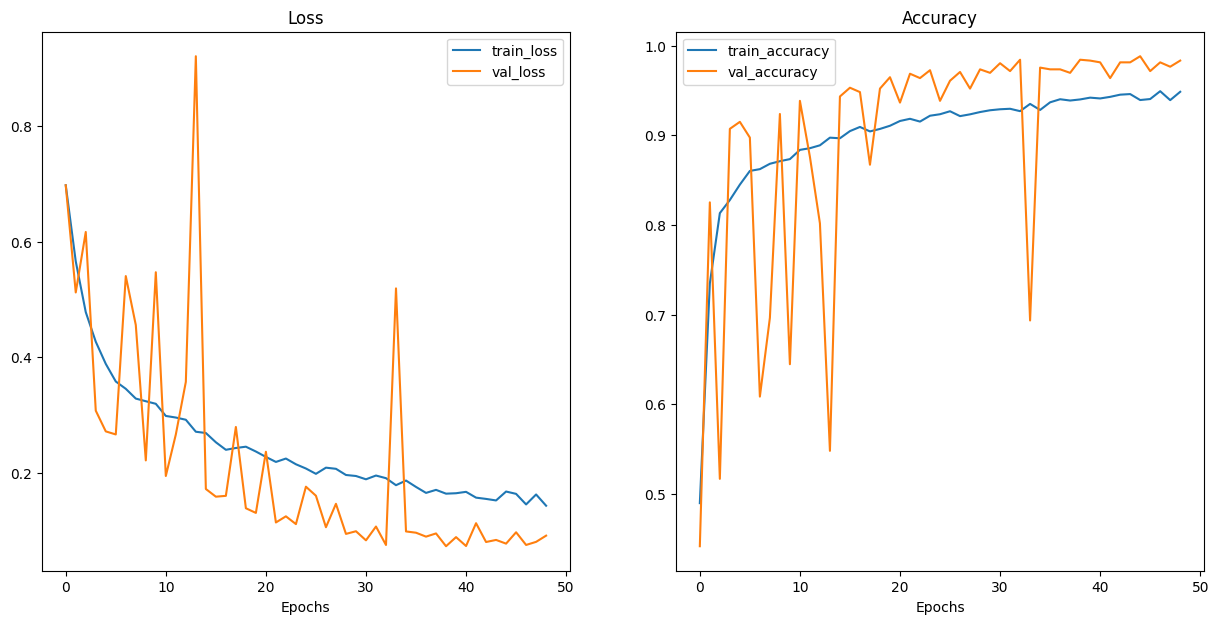

In [35]:
# Setup a plot
plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(results_from_csv["epochs"], results_from_csv["train_loss"], label="train_loss")
plt.plot(results_from_csv["epochs"], results_from_csv["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(
    results_from_csv["epochs"], results_from_csv["train_acc"], label="train_accuracy"
)
plt.plot(results_from_csv["epochs"], results_from_csv["val_acc"], label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

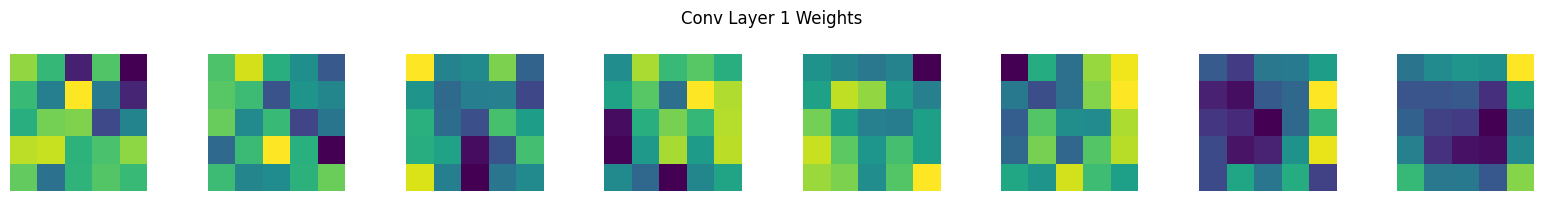

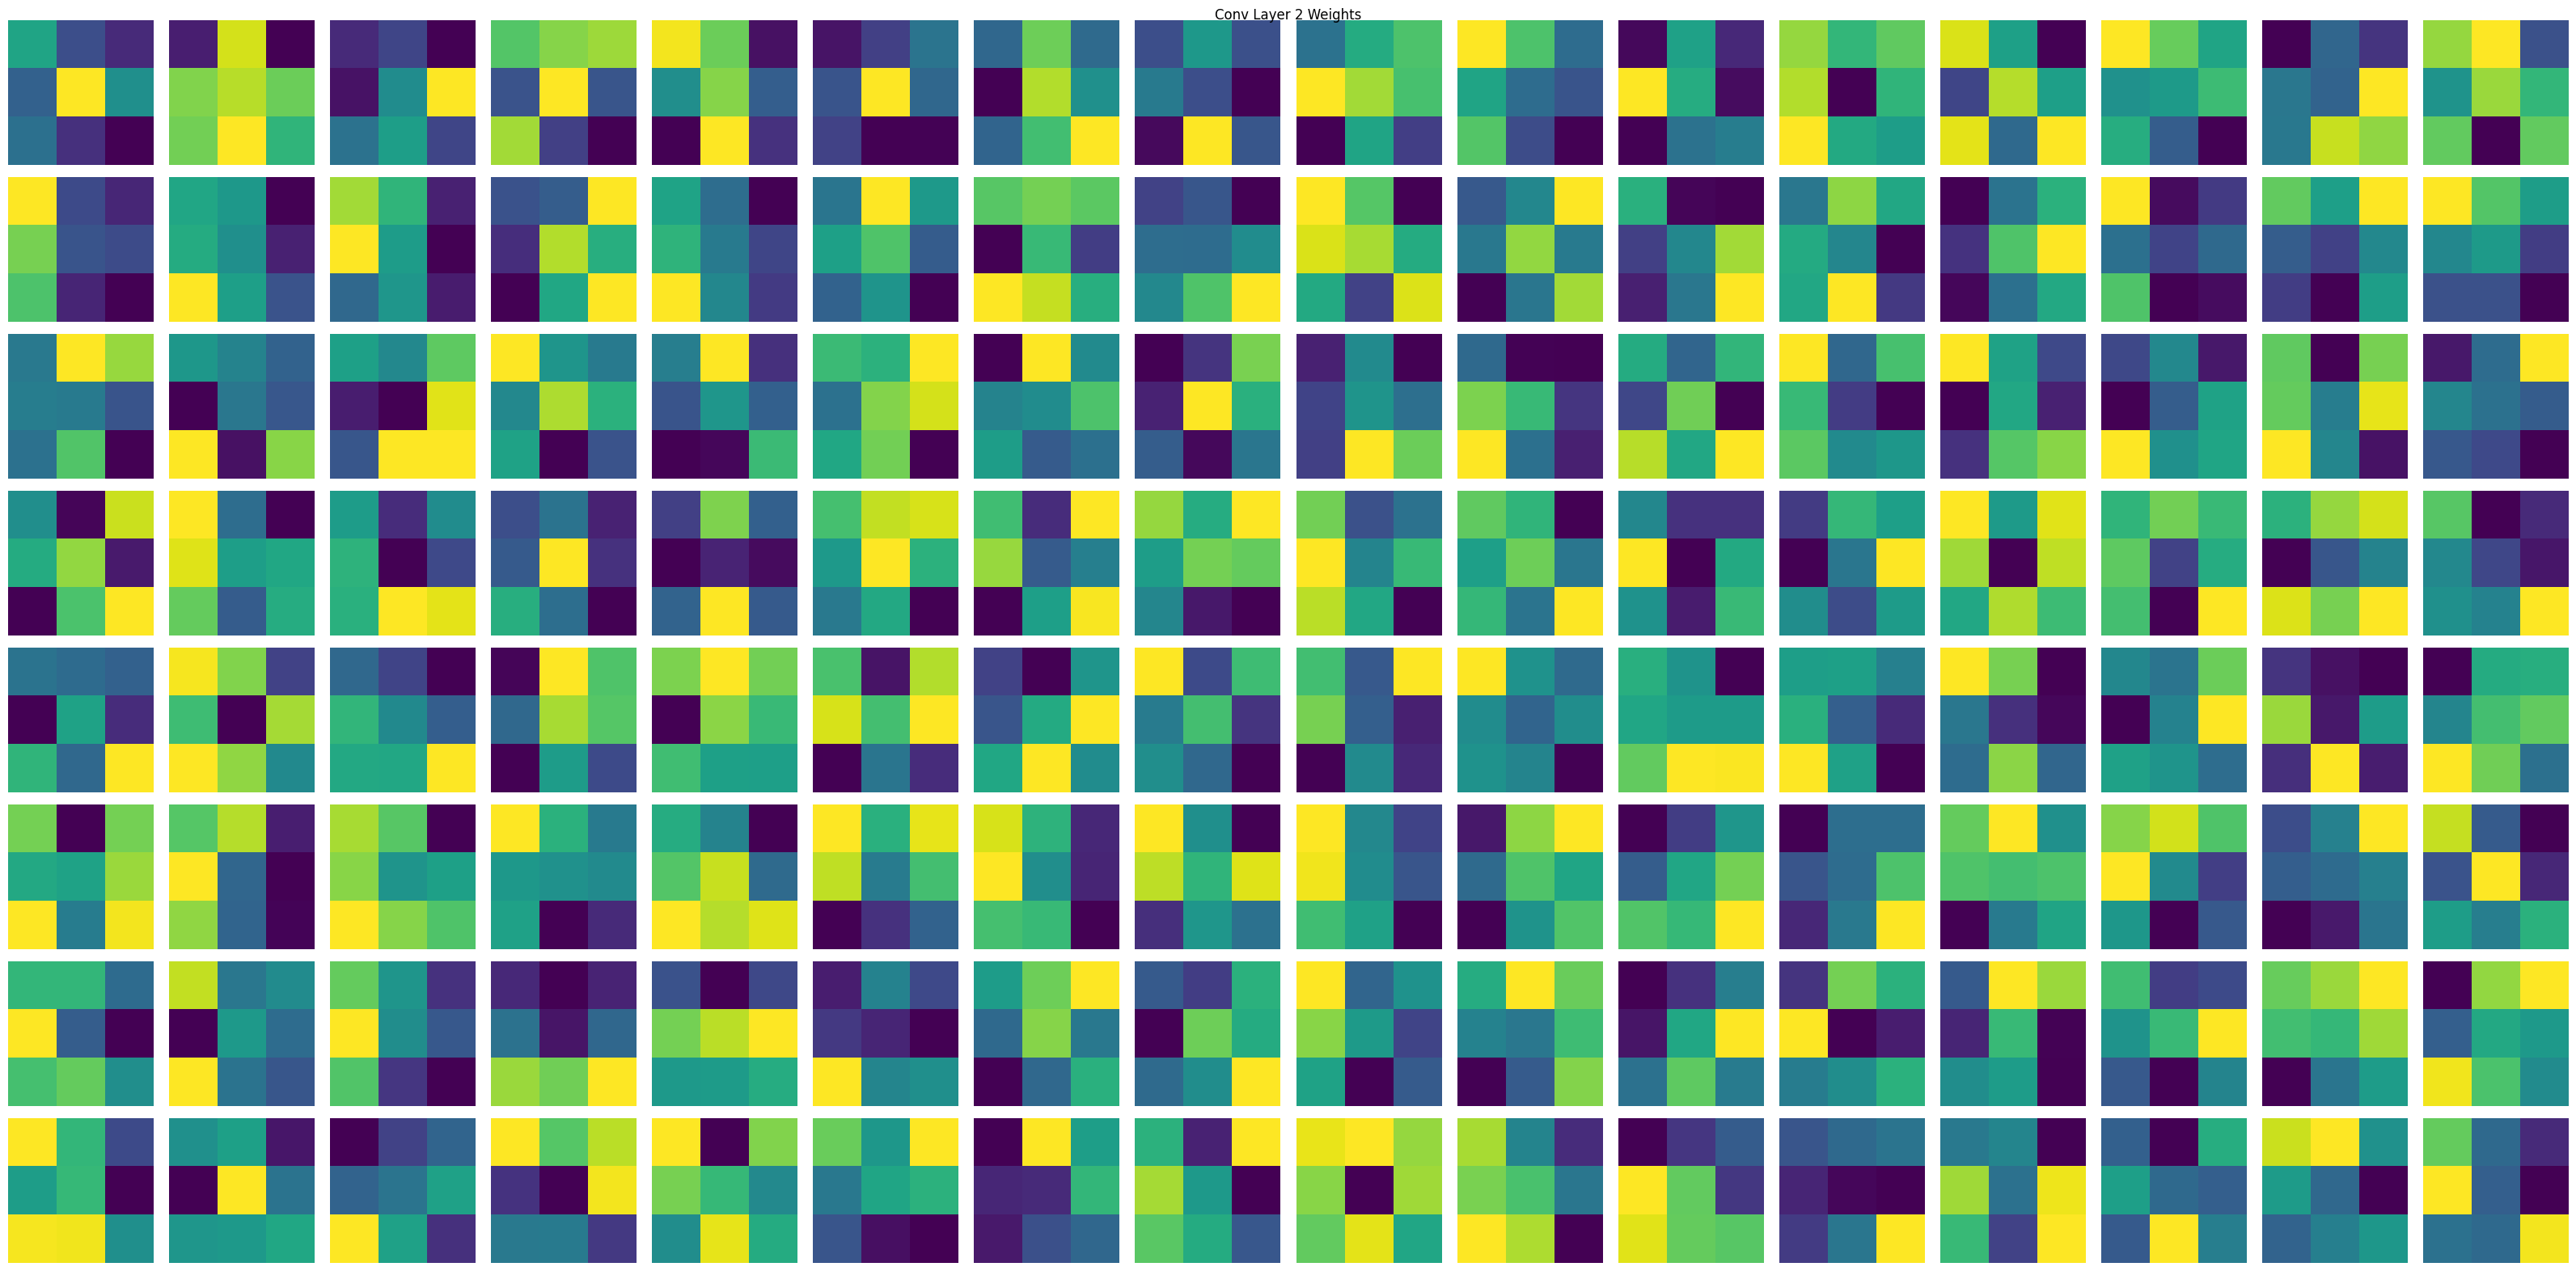

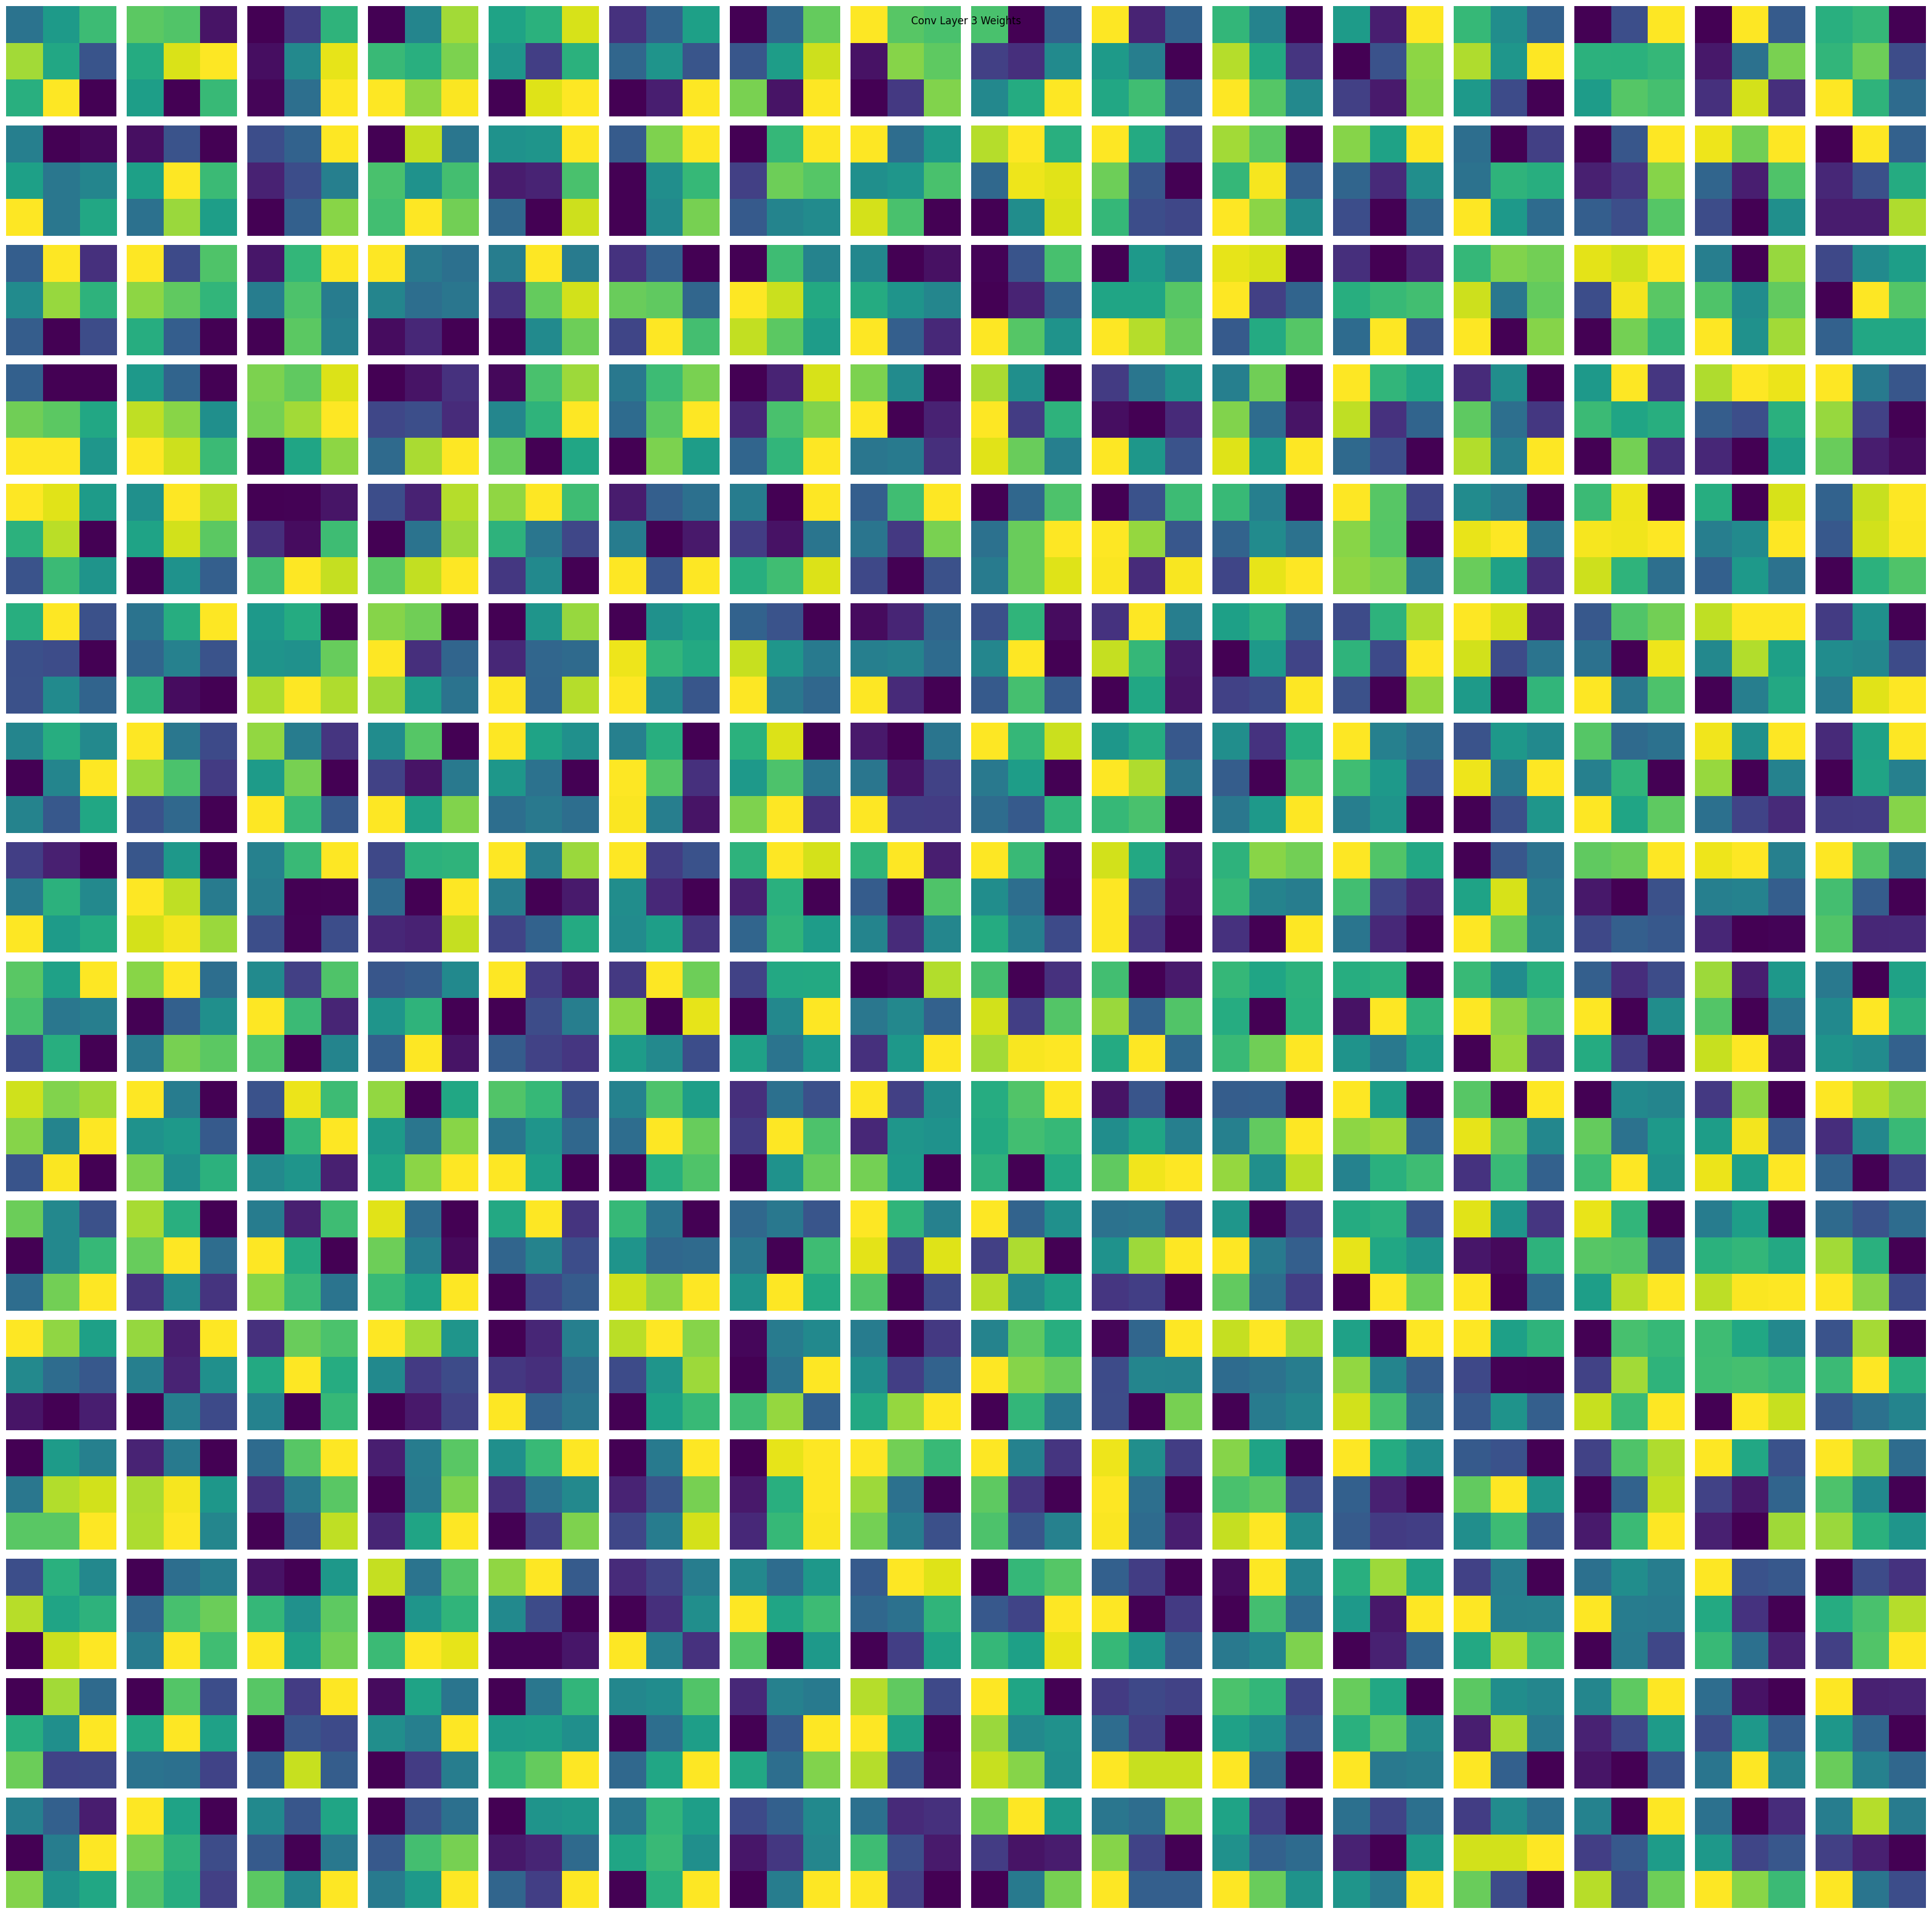

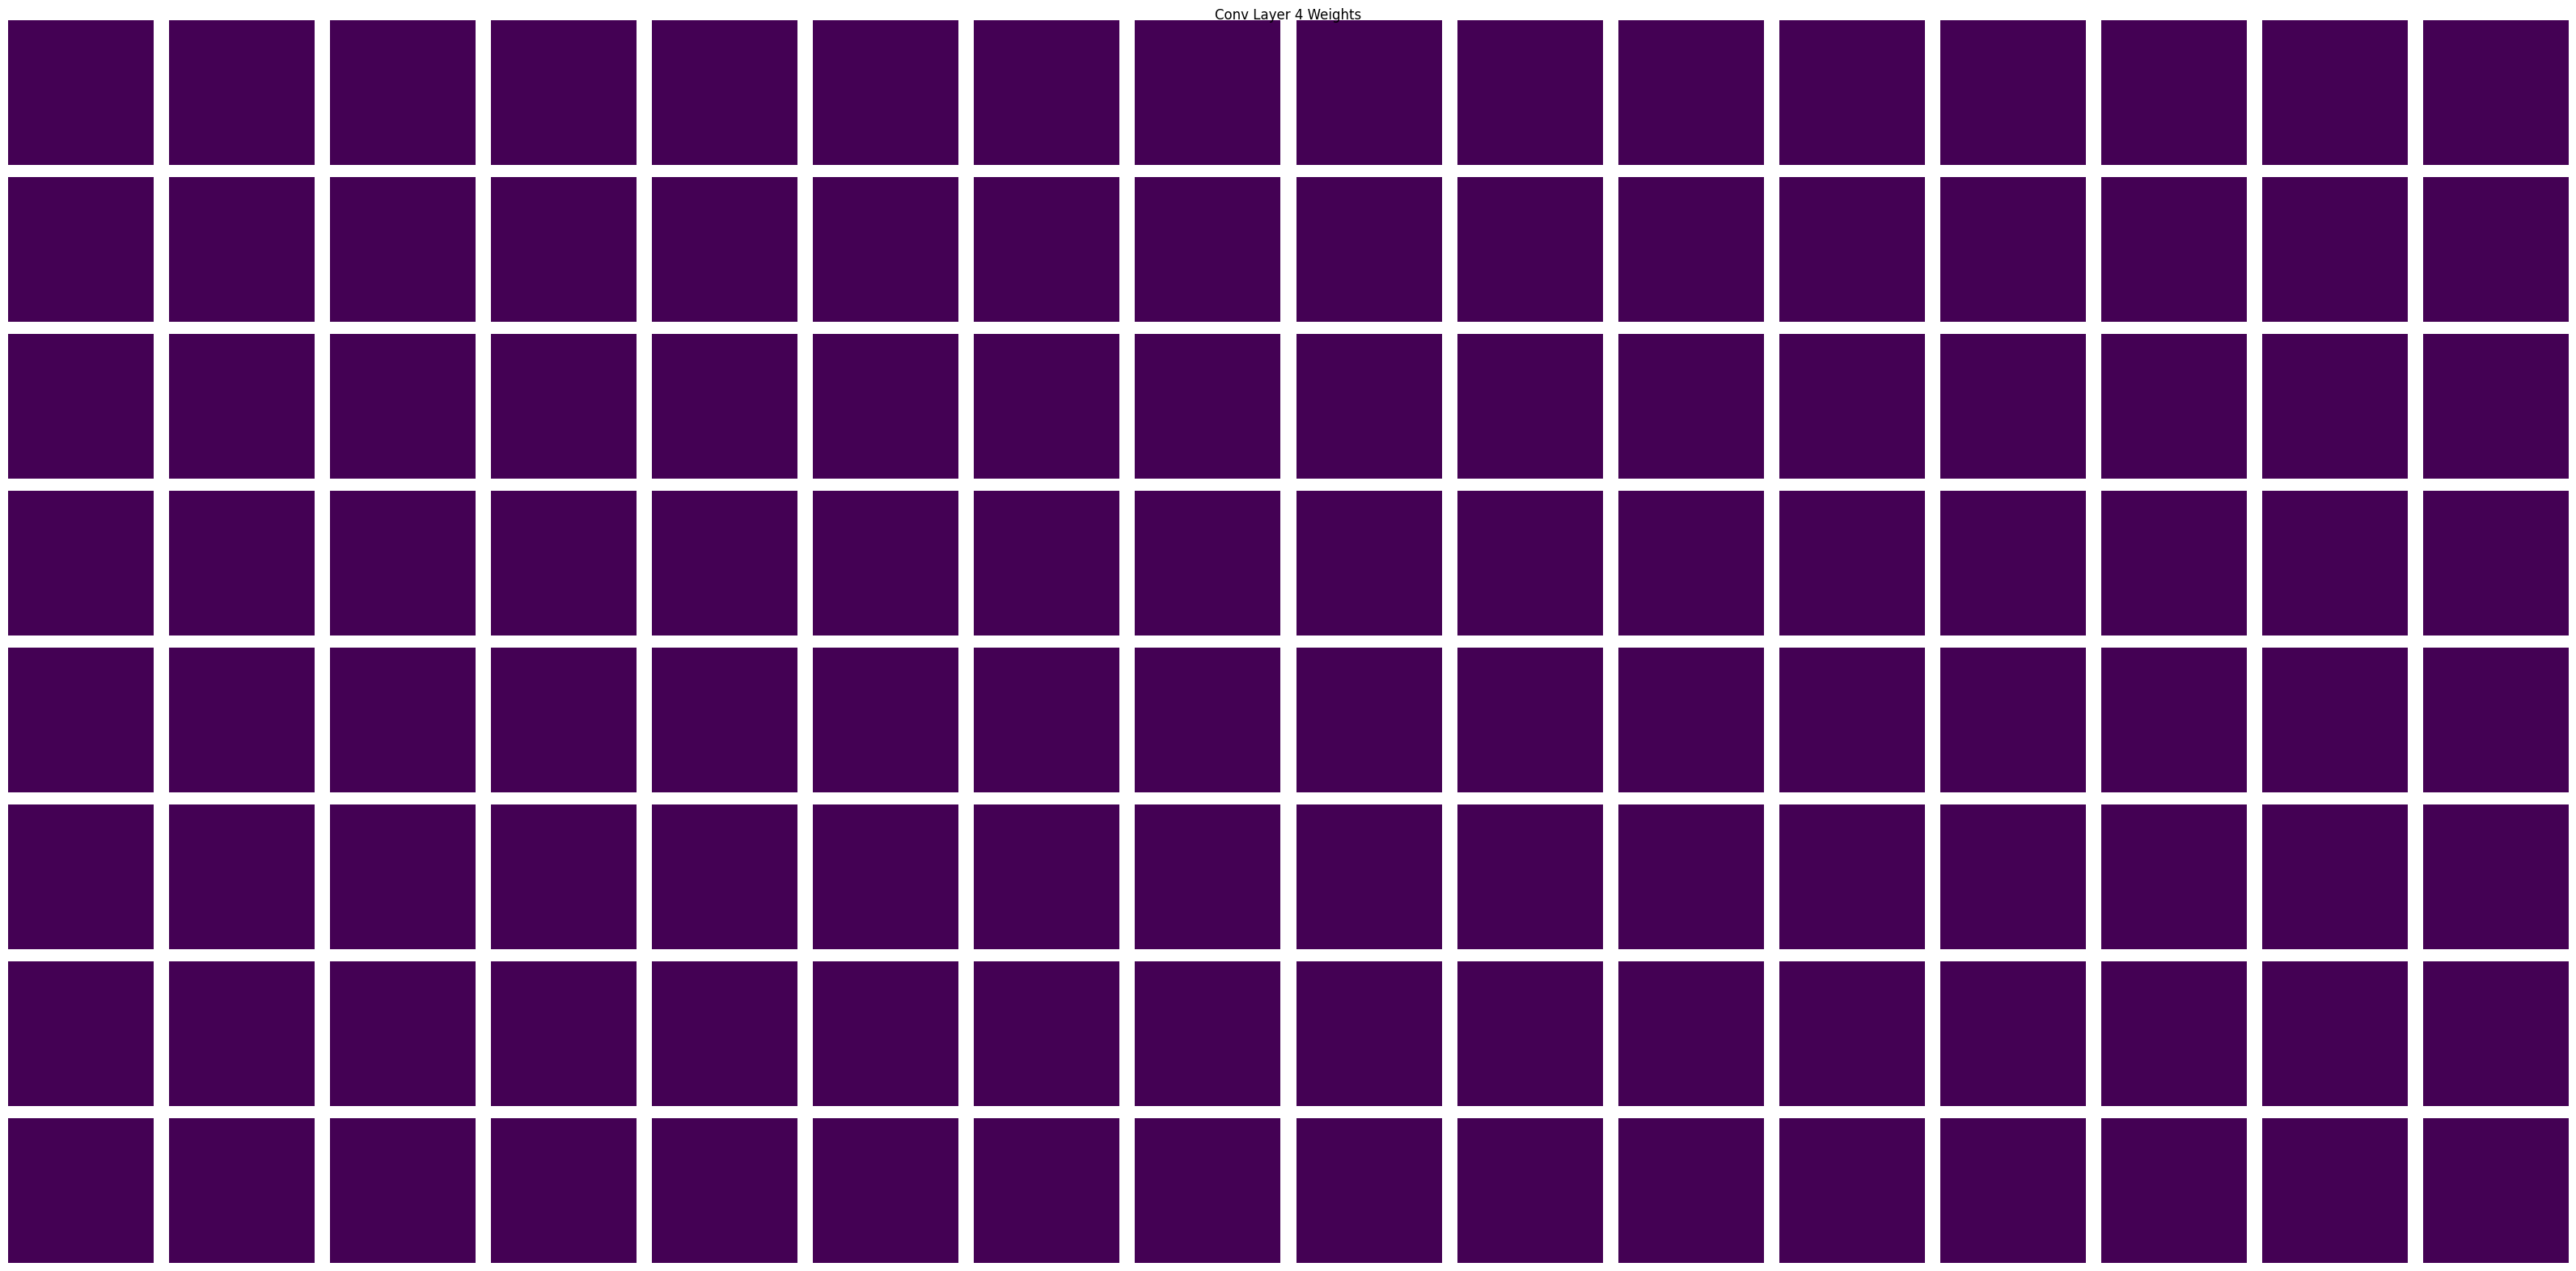

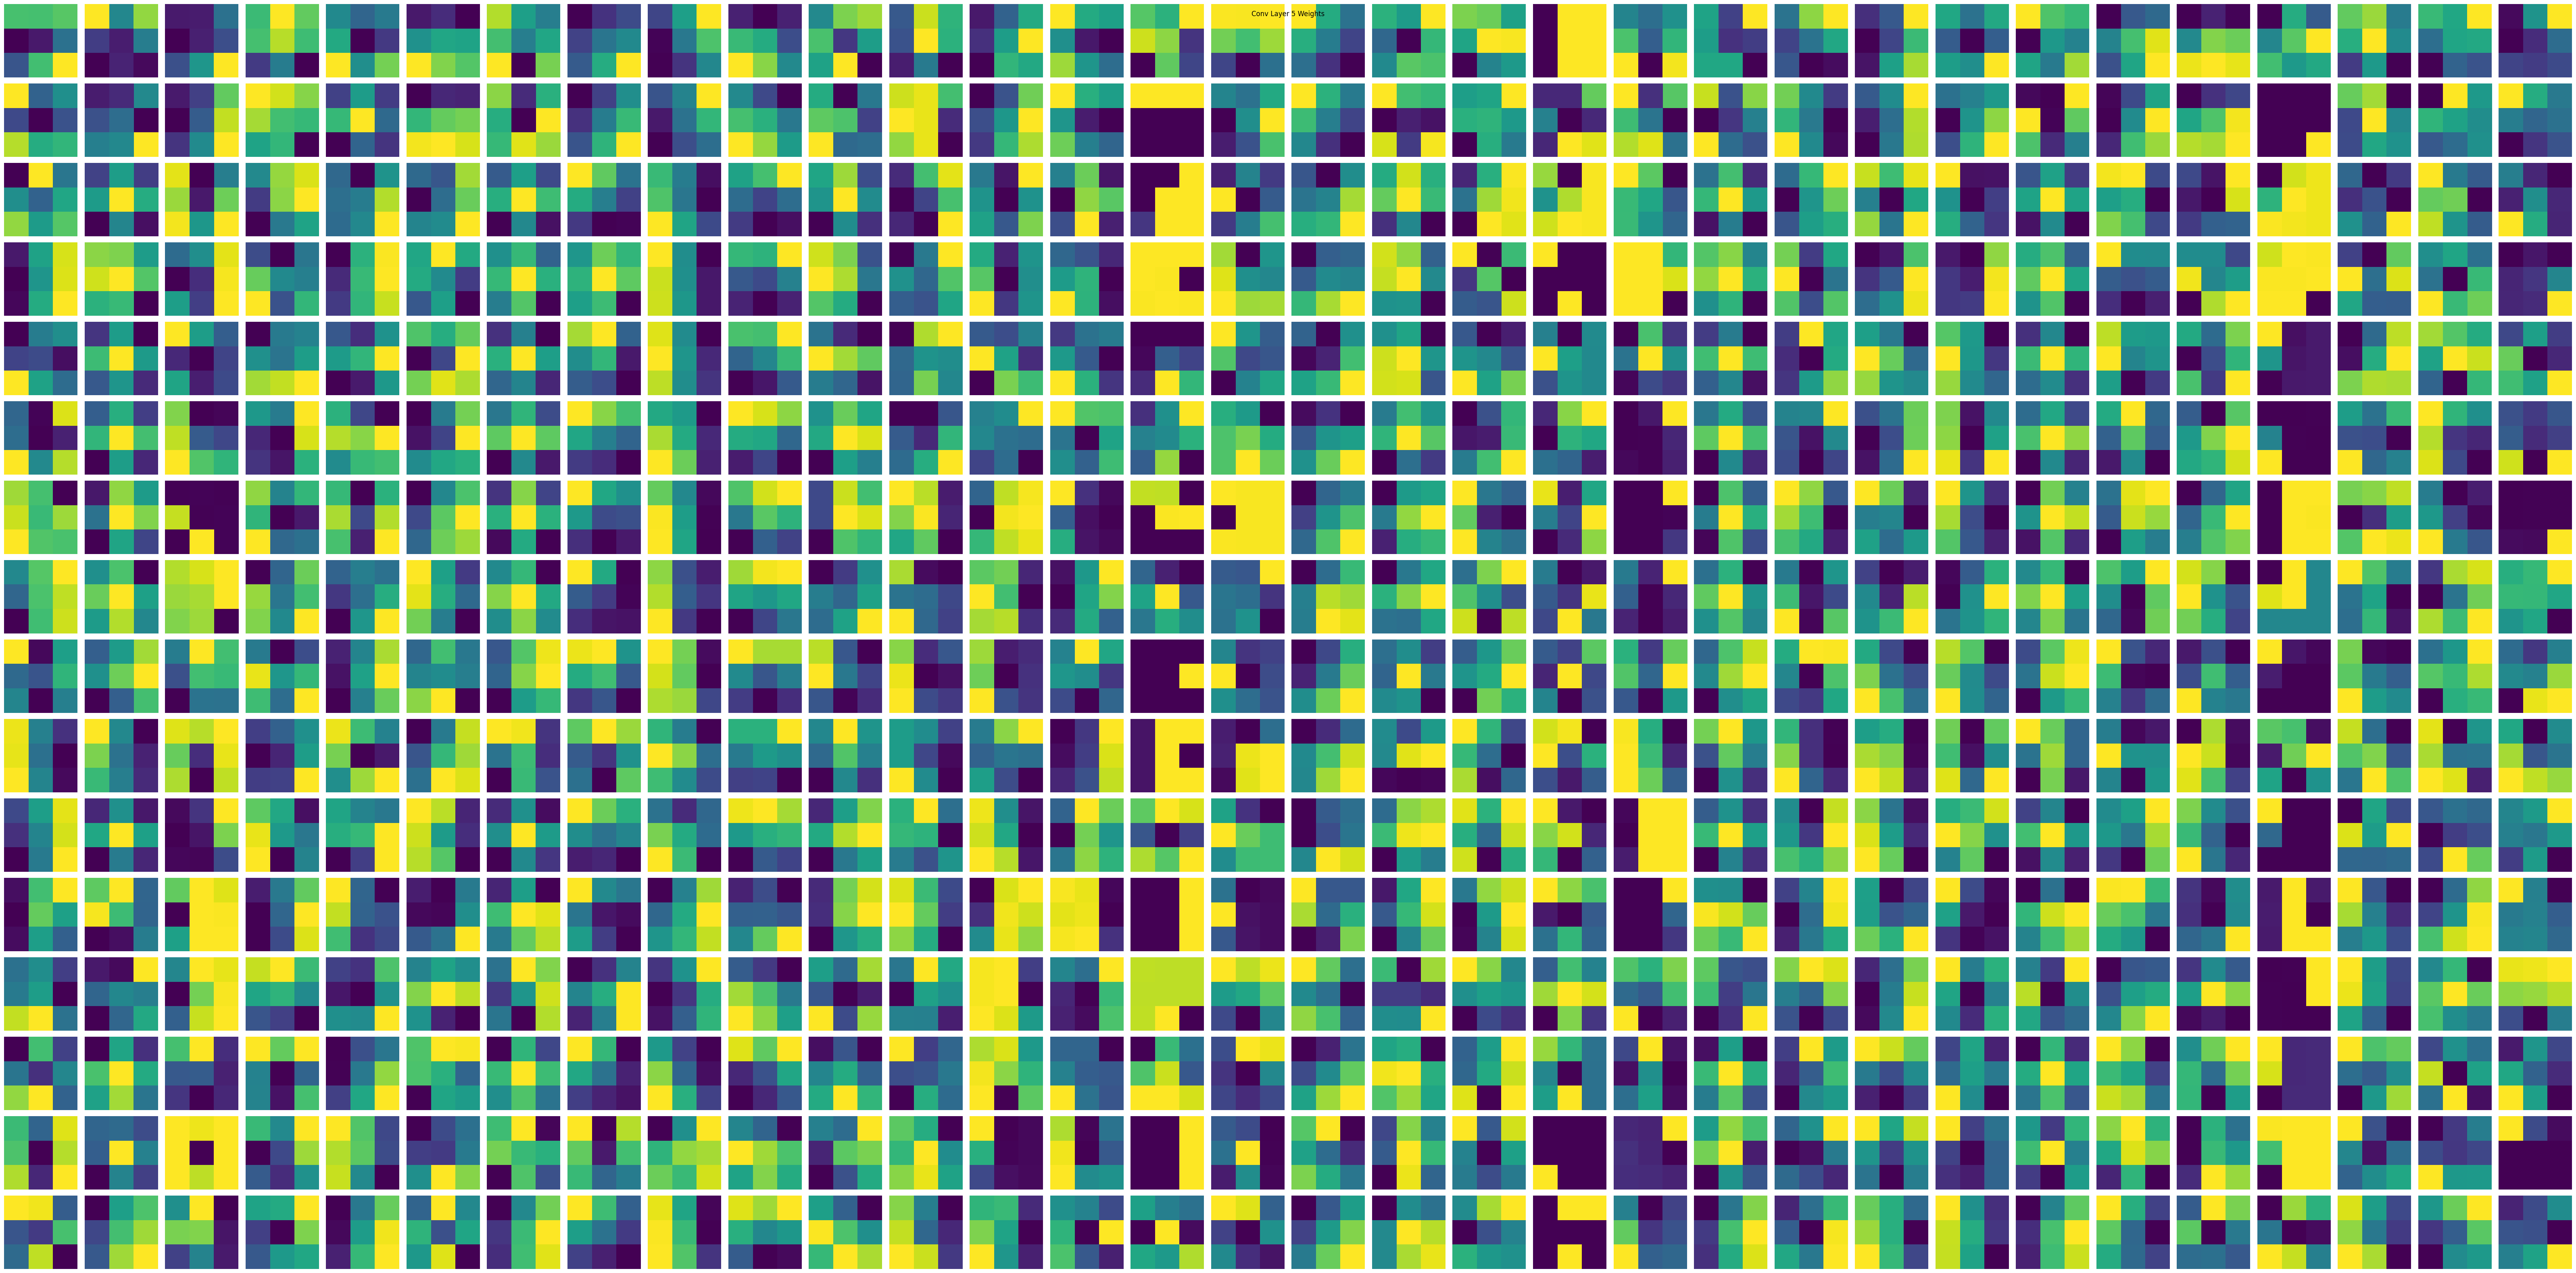

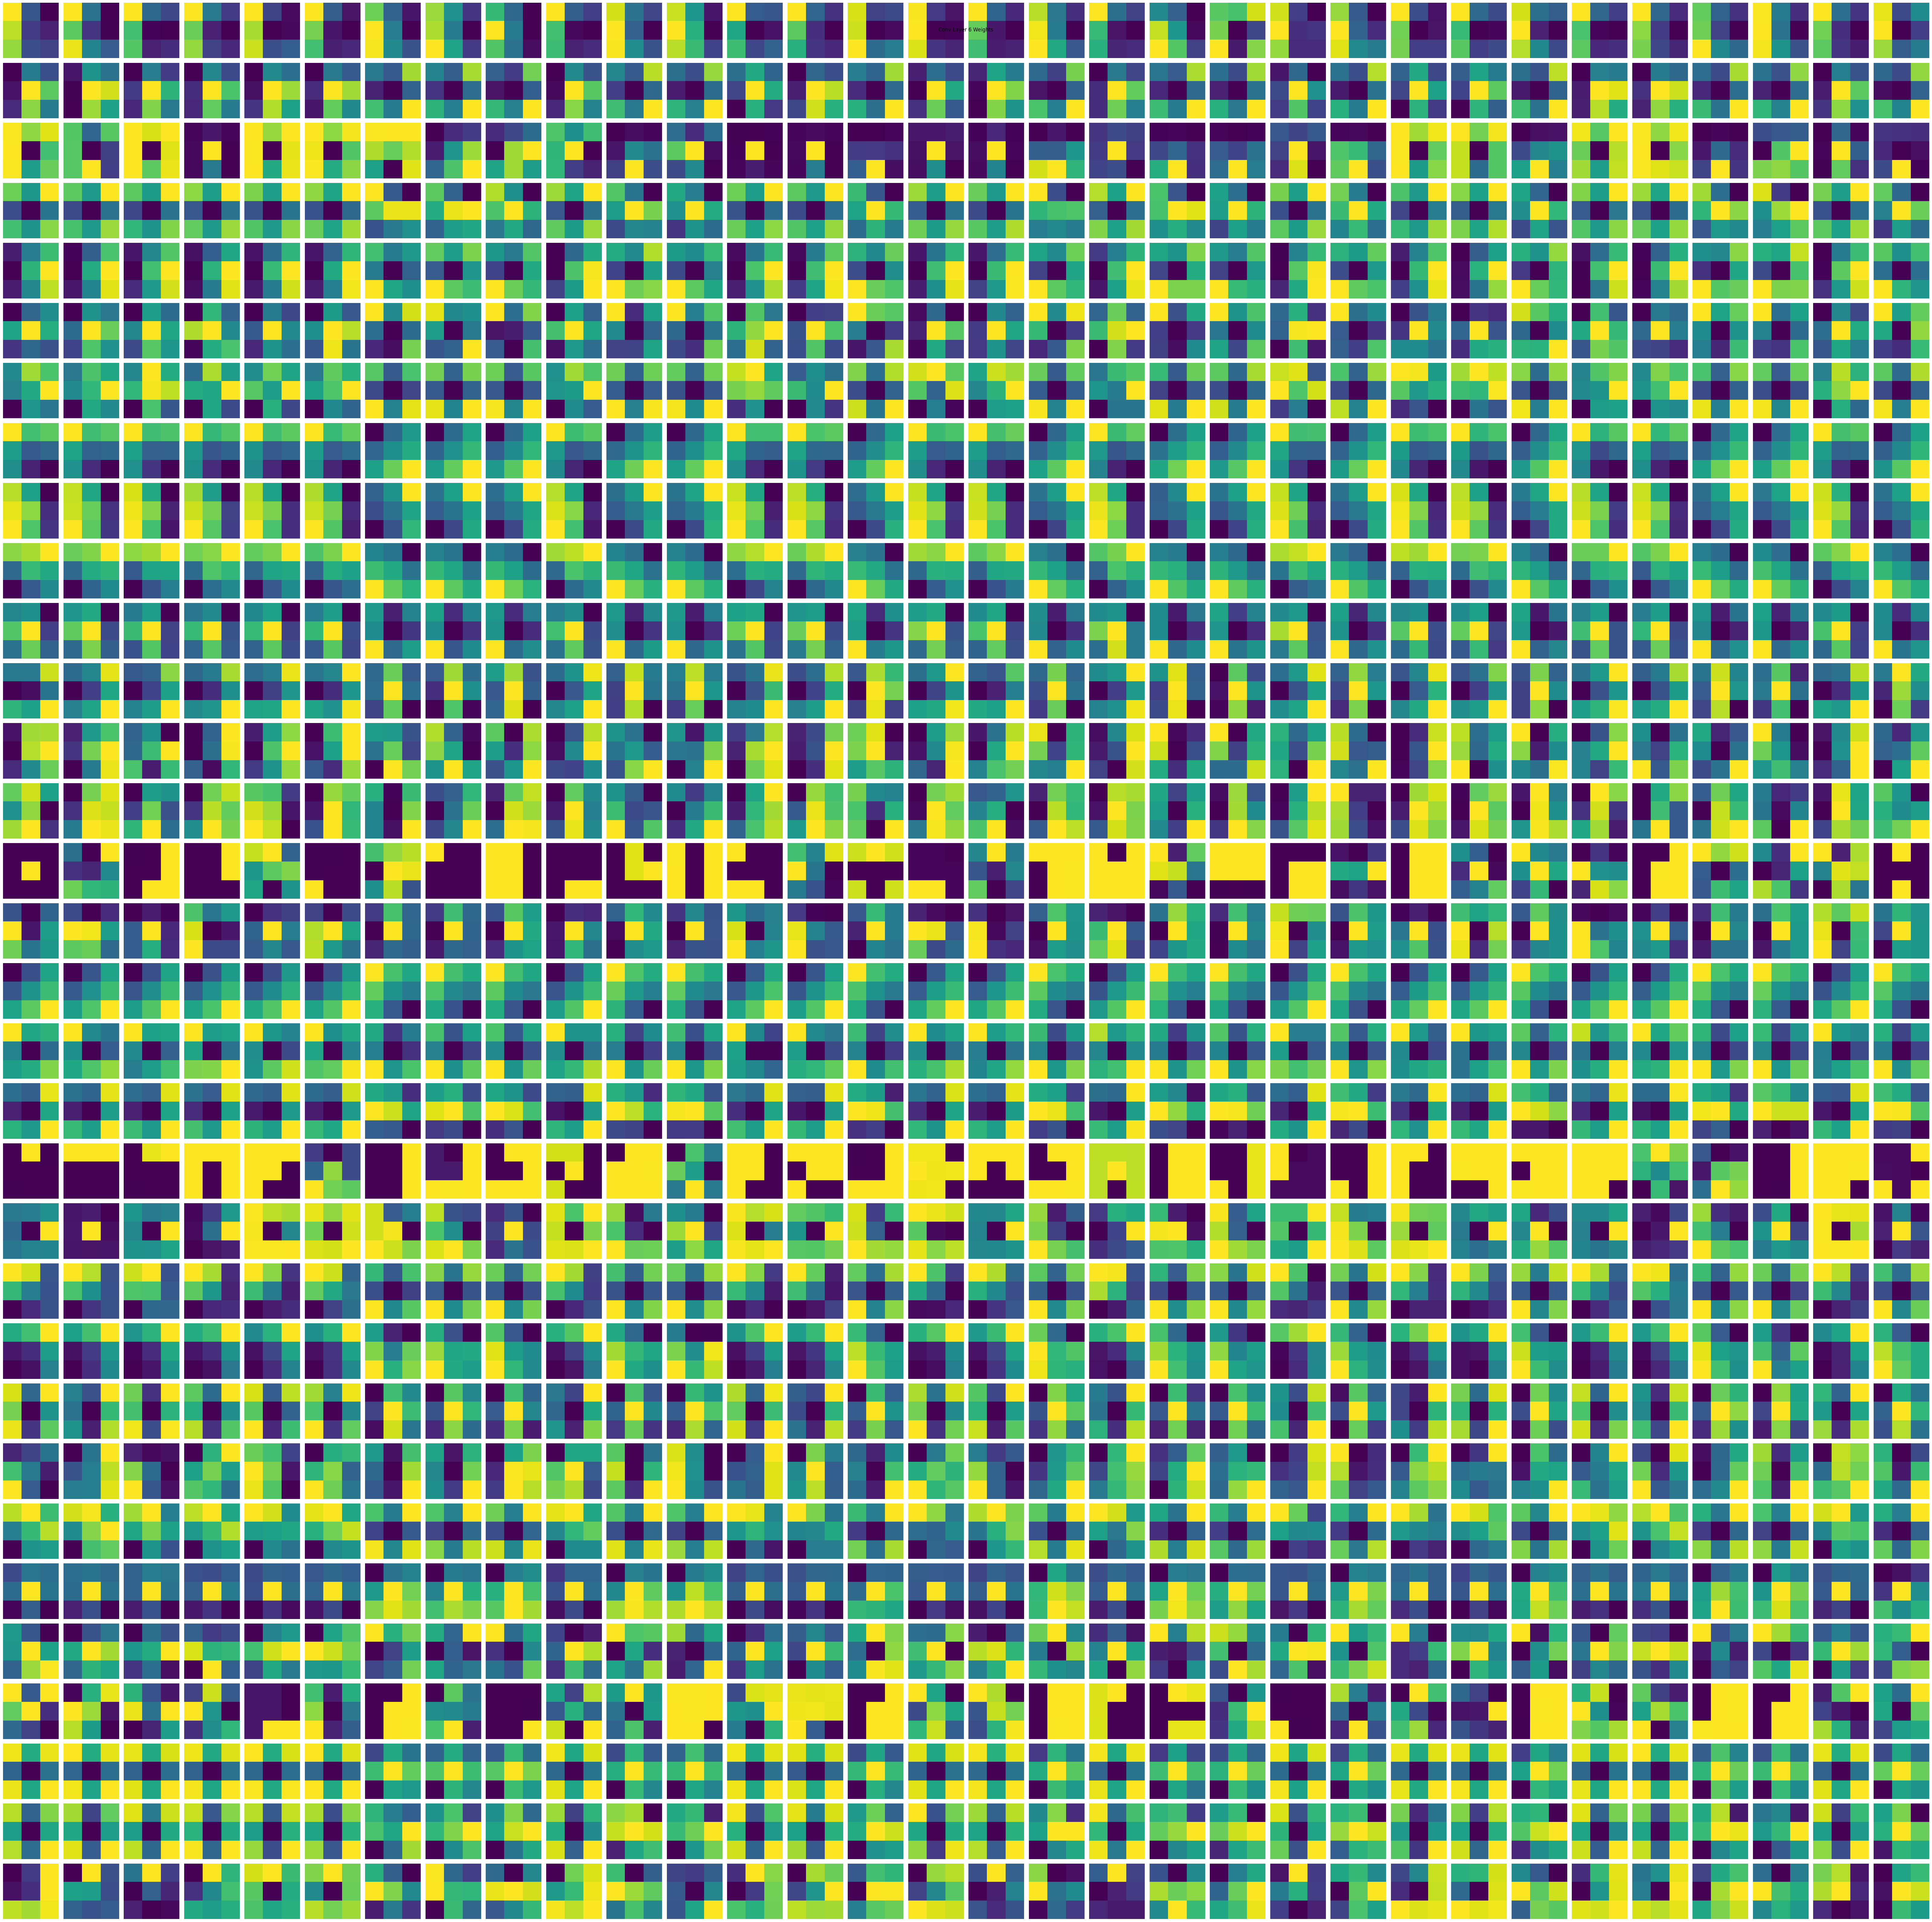

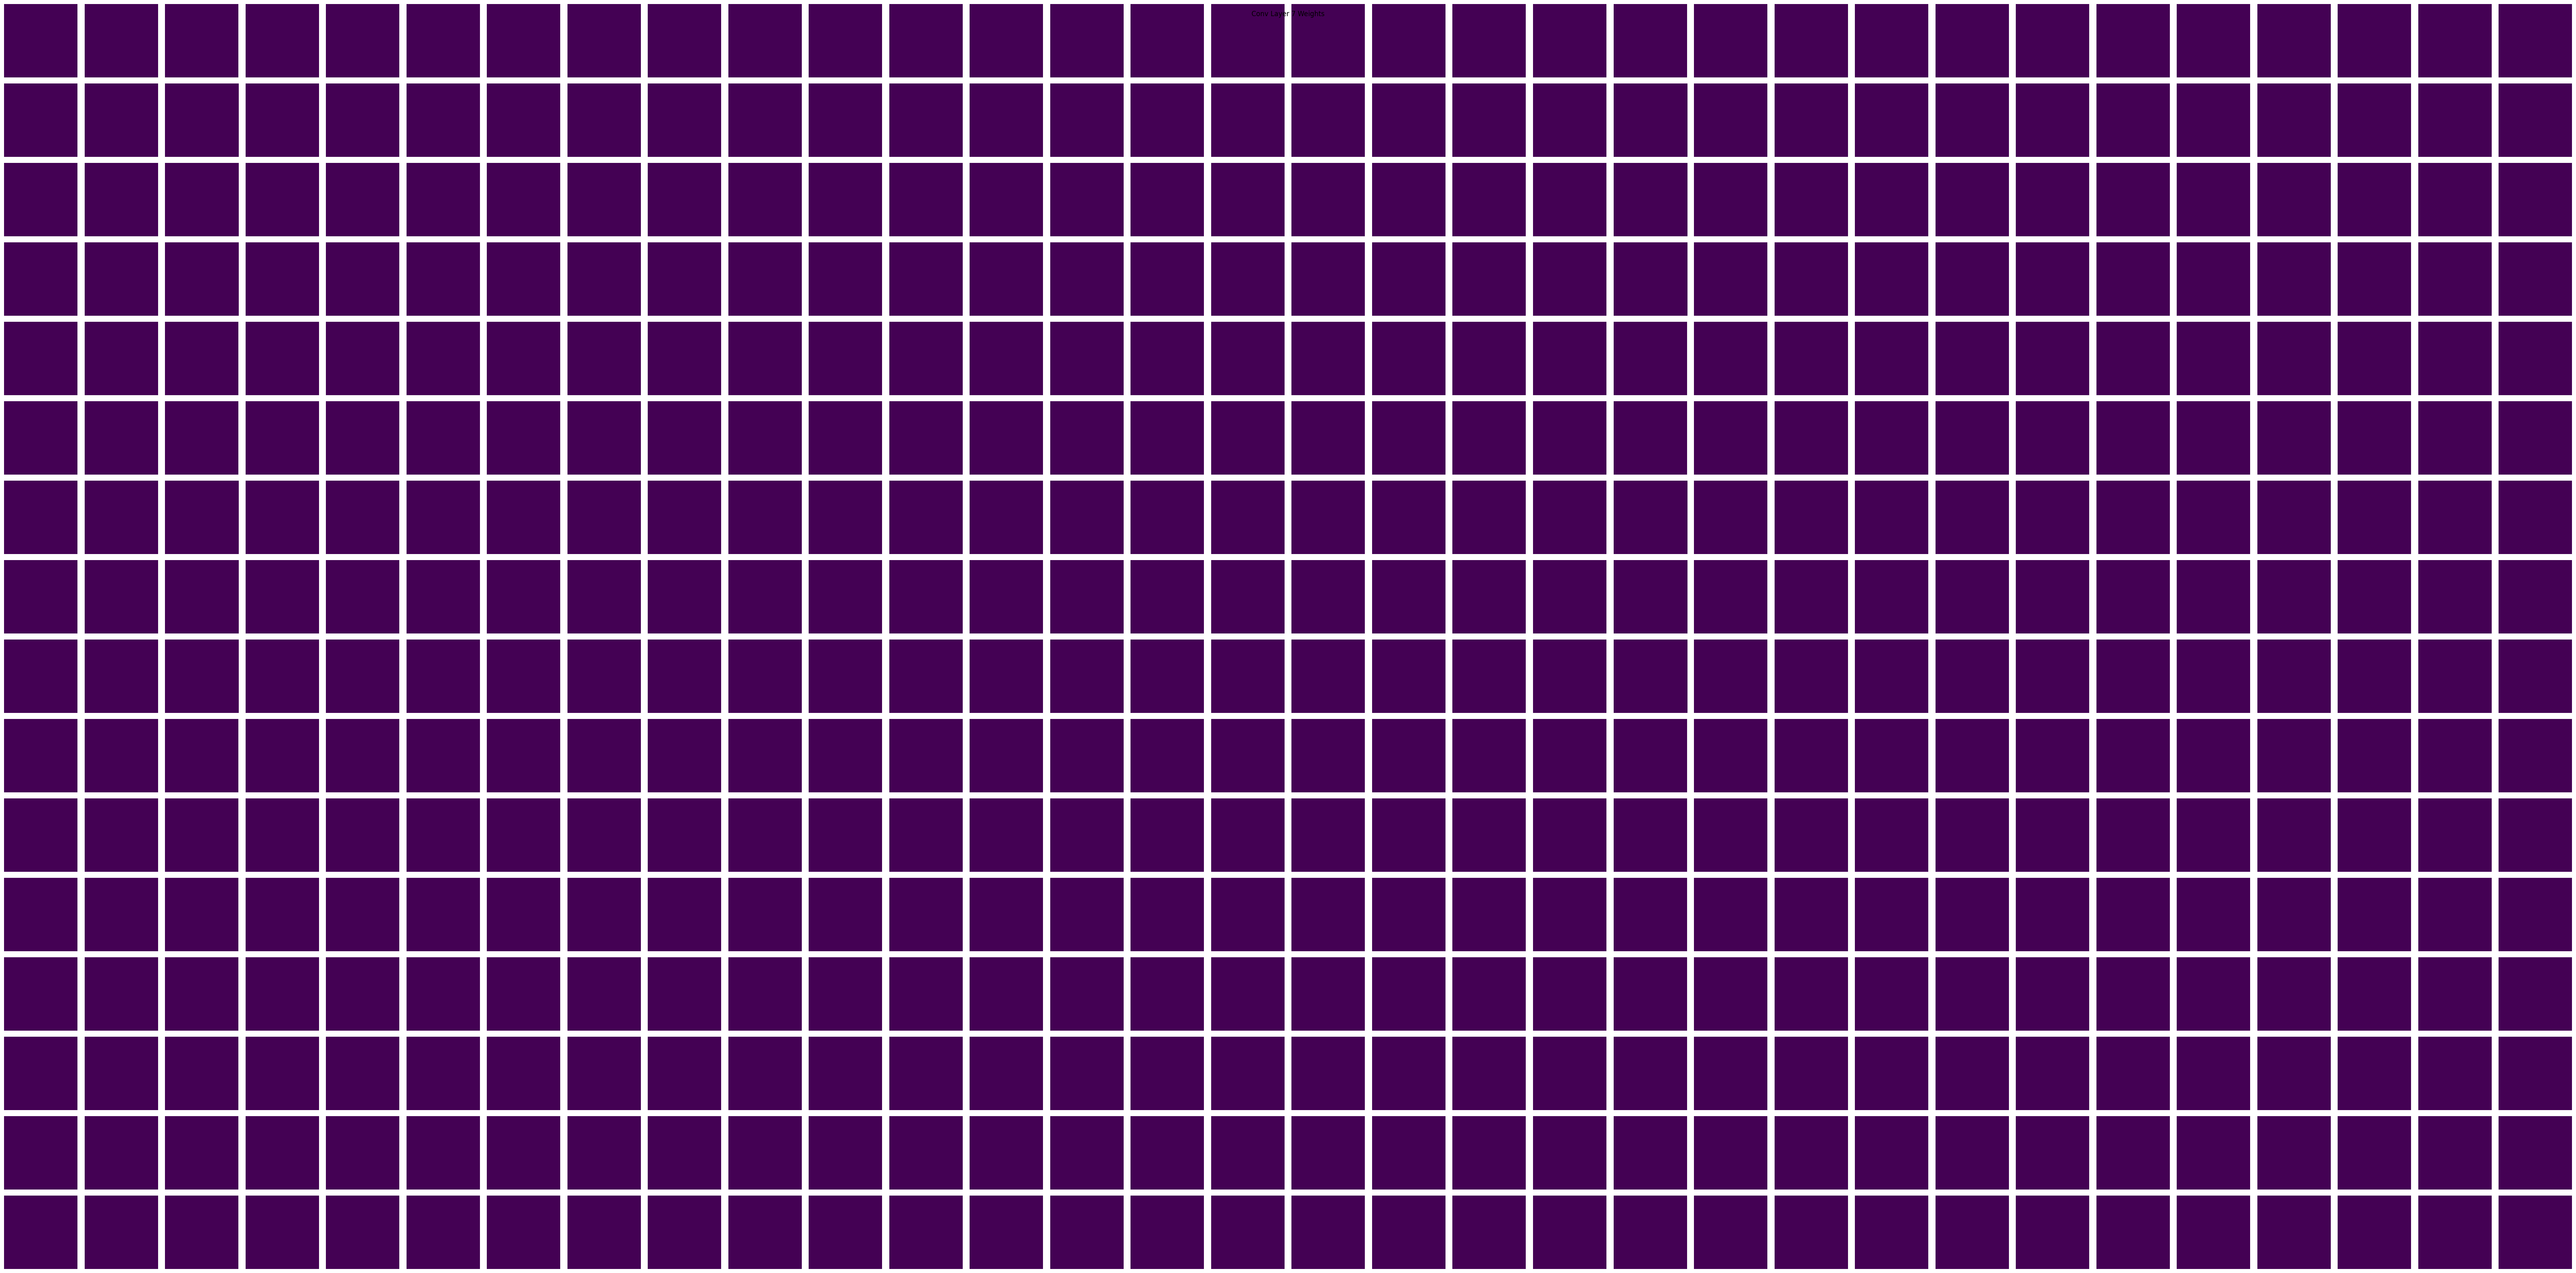

In [36]:
# inspect filters
conv_layers = []
for module in model.modules():
    if isinstance(module, torch.nn.Conv2d):
        conv_layers.append(module)

# Plot weights for each conv layer
for idx, conv_layer in enumerate(conv_layers):
    # Get weights and convert to numpy
    weights = conv_layer.weight.data.cpu().numpy()

    # Calculate grid size
    n_filters = weights.shape[0]
    n_channels = weights.shape[1]

    # Create figure
    fig, axes = plt.subplots(n_channels, n_filters,
                            figsize=(n_filters*2, n_channels*2))

    # Plot each filter's channels
    for i in range(n_filters):
        for j in range(n_channels):
            if n_channels == 1:
                ax = axes[i] if n_filters > 1 else axes
            else:
                ax = axes[j,i] if n_filters > 1 else axes[j]

            img = weights[i,j]
            ax.imshow(img, cmap='viridis')
            ax.axis('off')

    plt.suptitle(f'Conv Layer {idx+1} Weights')
    plt.tight_layout()
    plt.show()


In [ ]:
## You can find the model and result corresponding to each fold in the files inside the directory

# Continue the training and validation of the model for all the other folds
for i in range(1, 10):
    # Keeping the split
    train_str = "train_" + str(i)
    val_str = "val_" + str(i)
    train_idx = train_splits[train_str].values
    val_idx = val_splits[val_str].values
    mean = fold_stats[str(i)]["mean"]
    std = fold_stats[str(i)]["std"]

    # Create dataloaders with fold-specific normalization
    train_loader, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)

    # Start the timer
    from timeit import default_timer as timer

    start_time = timer()
    # Train model
    model_results = train(
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=NUM_EPOCHS,
        split=i,
    )
    # End the timer and print out how long it took
    end_time = timer()
    print(f"Total training time for split {i}: {end_time-start_time:.3f} seconds")
    # Extract train and validation loss and accuracy at each epoch
    results = dict(list(model_results.items()))
    # Get the loss values of the results dictionary (training and validation)
    train_loss = results["train_loss"]
    val_loss = results["val_loss"]
    # Get the accuracy values of the results dictionary (training and validation)
    train_acc = results["train_acc"]
    val_acc = results["val_acc"]
    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))
    # Save results in a csv
    results_df = pd.DataFrame(
        columns=["train_loss", "val_loss", "train_acc", "val_acc", "epochs"]
    )
    results_df["train_loss"] = train_loss
    results_df["val_loss"] = val_loss
    results_df["train_acc"] = train_acc
    results_df["val_acc"] = val_acc
    results_df["epochs"] = epochs
    results_df_name = basedir + "results_df_" + str(i) + ".csv"
    results_df.to_csv(results_df_name)

  2%|▏         | 1/50 [01:18<1:04:19, 78.76s/it]

Epoch: 1 | train_loss: 0.1586 | train_acc: 0.9418 | val_loss: 0.0508 | val_acc: 0.9902


  4%|▍         | 2/50 [02:28<58:52, 73.59s/it]  

Epoch: 2 | train_loss: 0.1210 | train_acc: 0.9588 | val_loss: 0.0609 | val_acc: 0.9824


  6%|▌         | 3/50 [03:37<55:53, 71.35s/it]

Epoch: 3 | train_loss: 0.1284 | train_acc: 0.9536 | val_loss: 0.0529 | val_acc: 0.9863


  8%|▊         | 4/50 [04:45<53:51, 70.26s/it]

Epoch: 4 | train_loss: 0.1433 | train_acc: 0.9499 | val_loss: 0.0804 | val_acc: 0.9775


 10%|█         | 5/50 [05:55<52:26, 69.92s/it]

Epoch: 5 | train_loss: 0.1529 | train_acc: 0.9497 | val_loss: 0.0628 | val_acc: 0.9834


In [ ]:
# Loading the checkpoint
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device(device))
    model = checkpoint["model"]
    model.load_state_dict(checkpoint["state_dict"])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model

In [ ]:
def f1_score(y_true, y_pred):
    tp = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    # Avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    # Avoid division by zero
    f1 = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) != 0
        else 0
    )
    return f1


def accuracy_score(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    accuracy = correct / len(y_true)
    return accuracy


def compute_metrics(model, dataloader):
    model.eval()
    y_true = np.array([])
    y_pred = np.array([])
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            y_pred_class = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            y_true = np.concatenate((y_true, labels.cpu().numpy()))
            y_pred = np.concatenate((y_pred, y_pred_class.cpu().numpy()))

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, f1


accuracies = []
f1_scores = []
# Iterate through all folds (0-9)
for i in range(10):
    model = load_checkpoint(basedir + "checkpoint_" + str(i) + ".pth")
    train_str = "train_" + str(i)
    val_str = "val_" + str(i)
    train_idx = train_splits[train_str].values
    val_idx = val_splits[val_str].values
    mean = fold_stats[str(i)]["mean"]
    std = fold_stats[str(i)]["std"]
    _, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)
    accuracy, f1 = compute_metrics(model, val_loader)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    print(f"Accuracy for split {i}: {accuracy}")
    print(f"F1 Score for split {i}: {f1}")


mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean F1 Score: {mean_f1_score}")